# Explorative analysis for extrapolation of cic savings data across multiple years

- Determine average temperature on certain days / months vs. average temperatures that we have measured.
- Extrapolate expected temperatures based on this comparison
- Determine heat demand based on these temperatures
- with COP / temperature and %-by-hp / temperature determine heat by hp extrapolated and energy consumption extrapolated


Inputs:  
etmgeg_260.txt: text file containing KNMI weather measurements in the Bilt 1901-aug2023

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from urllib.parse import urlparse
import pymysql
import os
import importlib
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

import numpy as np

from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

importlib.reload(sns)

<module 'seaborn' from '/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/seaborn/__init__.py'>

# load data

In [3]:
# load temperature data from file
with open('./data/etmgeg_260.txt','r') as f:
    content = f.readlines()
    header = content[51].split(',')
    header = [h.strip() for h in header]
    data = [line.split(',') for line in content[53:-1]]

    df_knmi = pd.DataFrame(columns=header, data=data)

In [4]:
# get data from mysql or local
if os.path.isfile('./data/cic_data.csv'):
    # load csv file
    df_cic = pd.read_csv('./data/cic_data.csv')

else:
    MYSQL_URL = os.environ['MYSQLDEV']
    parsed_mysql_url = urlparse(MYSQL_URL)

    try:
        connection = pymysql.connect(host=parsed_mysql_url.hostname,
                                    user=parsed_mysql_url.username,
                                    password=parsed_mysql_url.password,
                                    database=parsed_mysql_url.path[1:],
                                    port=parsed_mysql_url.port,
                                    autocommit=True)
        cursor = connection.cursor()
        if cursor.connection:
            # get energyConsumption
            cursor.execute('''SELECT * FROM cic_data_daily''')
            fields = [field_md[0] for field_md in cursor.description]
            result = [dict(zip(fields,row)) for row in cursor.fetchall()]
            df_cic = pd.DataFrame(result)
            df_cic.to_csv('./data/cic_data.csv', index=False)
    except:
        print("Error while connecting to MySQL")
    finally:
        cursor.close()
        connection.close()

In [19]:
# load expected savings data:
df_savings = pd.read_csv('./data/EnergyConsumption_test_data2.csv')
df_cic_prod = pd.read_csv('./data/prod_cic.csv')

# merge df_savings with df_cic
df_savings = pd.merge(df_savings, df_cic_prod, left_on='orderNr', right_on='orderNumber', how='left')
df_cic = pd.merge(df_cic, df_savings, left_on='cic_id', right_on='id_y', how='left')

# explore temperature

In [4]:
# add date columns to dataset
df_knmi['date'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d')
df_knmi['TG'] = df['TG'].astype(float)/10
df_knmi['year'] = df['date'].dt.year
df_knmi['month'] = df['date'].dt.month
df_knmi['day'] = df['date'].dt.day
df_knmi['month-day'] = df['date'].dt.strftime('%m-%d')

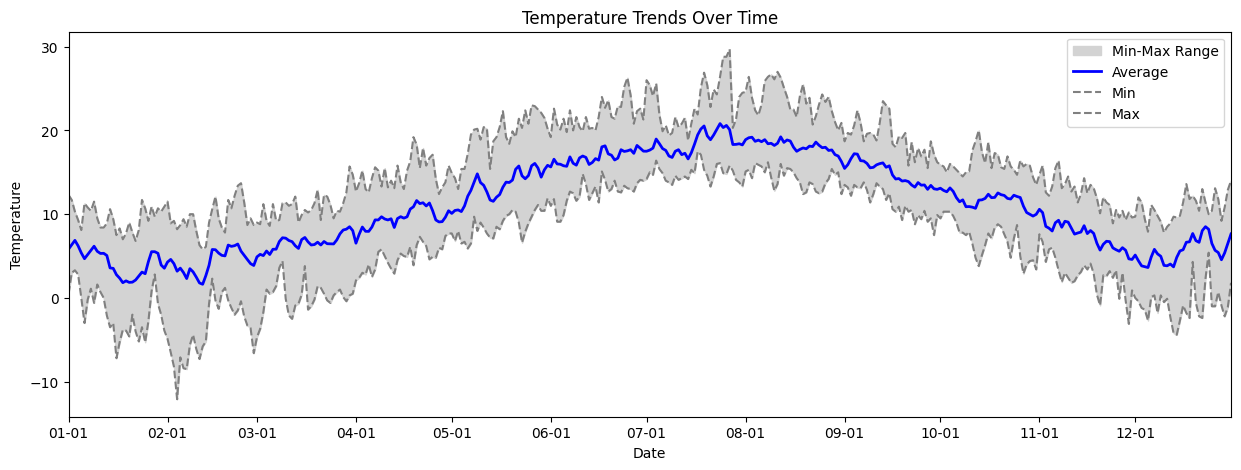

In [5]:
# create new dataframe with average temperature per day (for last 10 years)
df_year=pd.DataFrame()
df_year['month-day'] = df[df['year']==2022]['month-day']
# set month-day as index of frame
df_year = df_year.set_index('month-day')
for year in range(2012, 2023):
    df_year[f'TG-{year}'] = df[(df['year']==year) & (df['month-day']!='02-29')]['TG'].values

df_year['TG-avg'] = df_year.mean(axis=1)
df_year['TG-min'] = df_year.min(axis=1)
df_year['TG-max'] = df_year.max(axis=1)

# Plot temperature trend of the last 10 years
df_year['Date'] = pd.to_datetime(df_year.index, format='%m-%d')

# Plotting
plt.figure(figsize=(15, 5))

plt.fill_between(df_year['Date'], df_year['TG-min'], df_year['TG-max'], color='lightgrey', label='Min-Max Range')
plt.plot(df_year['Date'], df_year['TG-avg'], color='blue', linewidth=2, label='Average')
plt.plot(df_year['Date'], df_year['TG-min'], color='grey', linestyle='--', label='Min')
plt.plot(df_year['Date'], df_year['TG-max'], color='grey', linestyle='--', label='Max')


# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Trends Over Time')
plt.legend()

# Set x-axis limits to the minimum and maximum date values
plt.xlim(df_year['Date'].min(), df_year['Date'].max())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Show the plot
plt.show()

In [6]:
# Estimate and plot heat demand based on degree days
# assuming that: heat demand will go up linearly with temperature, however it's influenced by a factor which is dependant on the month (weighted degree days)
# add measured temperature to our dataframe
min_date = df_cic['date'].min()
max_date = df_cic['date'].max()

# make df_cic_avg dataframe which has all unique dates in df_cic as index ordered ascending
df_cic_avg = pd.DataFrame()
df_cic_avg['date'] = pd.date_range(min_date, max_date)

# for each date add the average min temp, average max temp, average average temp, and row count
df_cic_avg['temp_min'] = df_cic.groupby('date')['outside_temperature_min'].mean().values
df_cic_avg['temp_min_std'] = df_cic.groupby('date')['outside_temperature_min'].std().values
df_cic_avg['temp_max'] = df_cic.groupby('date')['outside_temperature_max'].mean().values
df_cic_avg['temp_max_std'] = df_cic.groupby('date')['outside_temperature_max'].std().values
df_cic_avg['temp_avg'] = df_cic.groupby('date')['outside_temperature_avg'].mean().values
df_cic_avg['temp_avg_std'] = df_cic.groupby('date')['outside_temperature_avg'].std().values
df_cic_avg['row_count'] = df_cic.groupby('date')['outside_temperature_avg'].count().values
df_cic_avg = pd.merge(df_cic_avg, df[['date','TG']], on = 'date', how='left')

# calculate differences between measured temperatures
df_cic_avg['temp_avg_diff'] = df_cic_avg['temp_avg'] - df_cic_avg['TG']

In [7]:
df_cic_avg['temp_avg_diff'].mean()

1.275107712261979

In [8]:
df_cic_avg[df_cic_avg['row_count']>15]['date'].min()

Timestamp('2022-11-30 00:00:00')

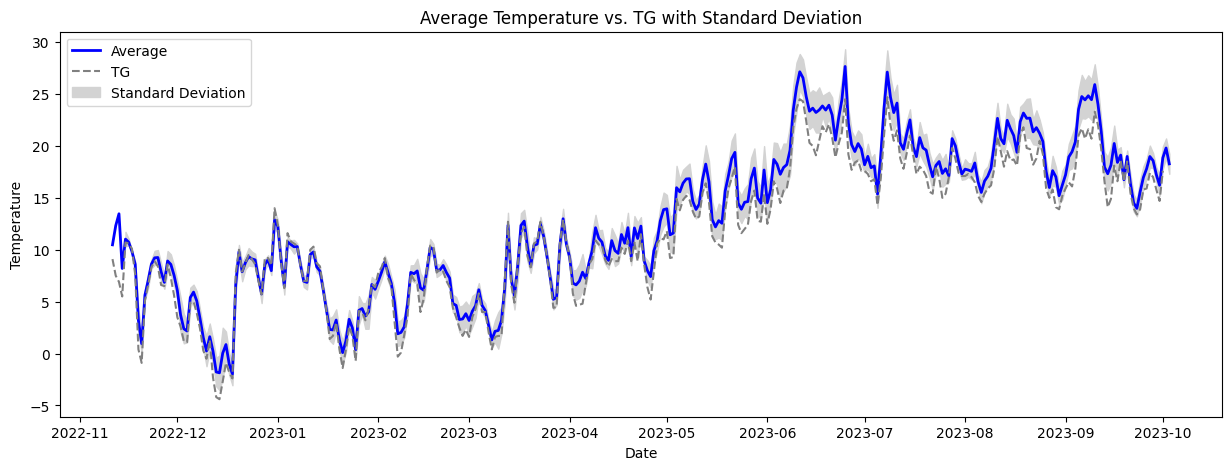

In [9]:
# Plotting
plt.figure(figsize=(15, 5))

# Plot average temperature
plt.plot(df_cic_avg['date'], df_cic_avg['temp_avg'], color='blue', linewidth=2, label='Average')

# Plot TG
plt.plot(df_cic_avg['date'], df_cic_avg['TG'], color='grey', linestyle='--', label='TG')

# Plot standard deviation as a shaded area
plt.fill_between(df_cic_avg['date'],
                 df_cic_avg['temp_avg'] - df_cic_avg['temp_avg_std'],
                 df_cic_avg['temp_avg'] + df_cic_avg['temp_avg_std'],
                 color='lightgrey', label='Standard Deviation')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Average Temperature vs. TG with Standard Deviation')
plt.legend()

# Show the plot
plt.show()

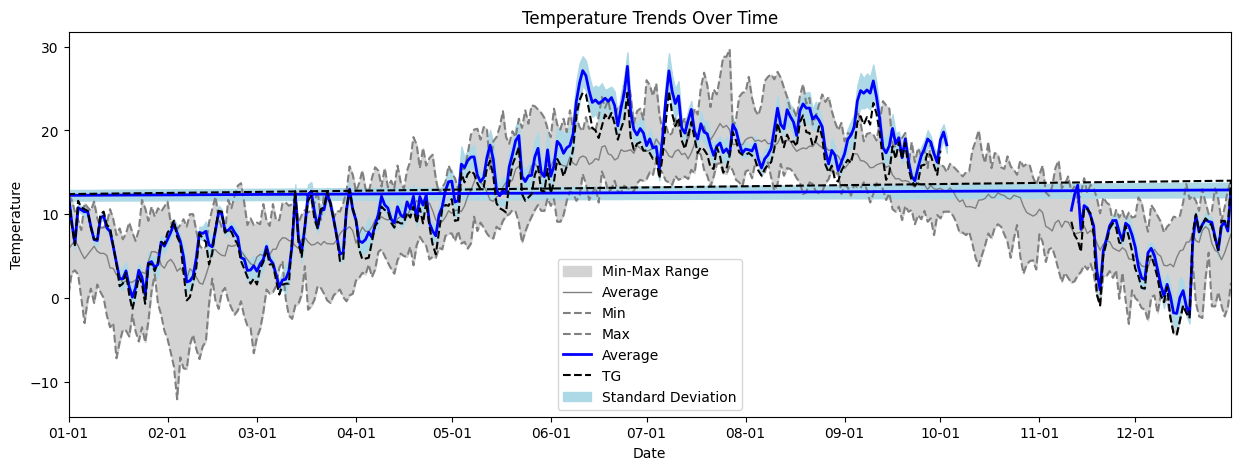

In [25]:
# Plotting
plt.figure(figsize=(15, 5))

plt.fill_between(df_year['Date'], df_year['TG-min'], df_year['TG-max'], color='lightgrey', label='Min-Max Range')
plt.plot(df_year['Date'], df_year['TG-avg'], color='grey', linewidth=1, label='Average')
plt.plot(df_year['Date'], df_year['TG-min'], color='grey', linestyle='--', label='Min')
plt.plot(df_year['Date'], df_year['TG-max'], color='grey', linestyle='--', label='Max')
# Plot average temperature measured
plt.plot(df_cic_avg['plotting_date'], df_cic_avg['temp_avg'], color='blue', linewidth=2, label='Average')
# Plot TG
plt.plot(df_cic_avg['plotting_date'], df_cic_avg['TG'], color='black', linestyle='--', label='TG')
# Plot standard deviation as a shaded area
plt.fill_between(df_cic_avg['plotting_date'],
                 df_cic_avg['temp_avg'] - df_cic_avg['temp_avg_std'],
                 df_cic_avg['temp_avg'] + df_cic_avg['temp_avg_std'],
                 color='lightblue', label='Standard Deviation')


# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Trends Over Time')
plt.legend()

# Set x-axis limits to the minimum and maximum date values
plt.xlim(df_year['Date'].min(), df_year['Date'].max())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Show the plot
plt.show()

In [23]:
df_cic_avg['plotting_date']  = pd.to_datetime(df_cic_avg['date'].dt.strftime('%m-%d'), format='%m-%d')
# df_year['Date']

Now, we check how much heat is produced at certain outdoor temperatures and at certain days of the year.
We want to know the relation between heat demand and temperature and heat demand and month.

In [28]:
print(df_savings.columns.values)

['id_x' 'created_at' 'updated_at' 'deal_id' 'orderNr'
 'aanbevolen_vermogen_warmtepomp' 'referentie_warmtevraag_per_m2'
 'geschiktheid_woning' 'aardgas_verbruik' 'bouwjaar' 'woning_type'
 'oppervlakte' 'afgiftesysteem' 'geschiktheidscategorie'
 'referentie_warmtevraag' 'gas_tbv_tapwater'
 'verbruik_gas_tbv_ruimteverwarming'
 'warmtevraag_woning_op_basis_van_verbruik'
 'vermogen_nodig_woning_warmteverlies_huis' 'stookgrens'
 'vermogen_op_basis_van_verbruik' 'beta_03' 'beta_07'
 'aanbevolen_vermogen_op_basis_van_beta_03'
 'aanbevolen_vermogen_op_basis_van_beta_07' 'vollasturen_max'
 'uren_boven_max' 'percentage_vollasturen_boven_max' 'vermogen'
 'beta_factor' 'dekking_warmtevraag_op_basis_van_woning'
 'dekking_warmtevraag_op_basis_van_beta_factor'
 'dekking_warmtevraag_totaal' 'dekking_warmtevraag_met_wp_theoretisch'
 'dekking_warmtevraag_van_warmtepomp' 'SPF' 'extra_verbruik_tbv_WP'
 'gas_besparing' 'CO2_extra_kWh' 'CO2_minder_gas' 'netto_minder_CO2'
 'elektriciteit' 'gas' 'kosten_extra

<Axes: >

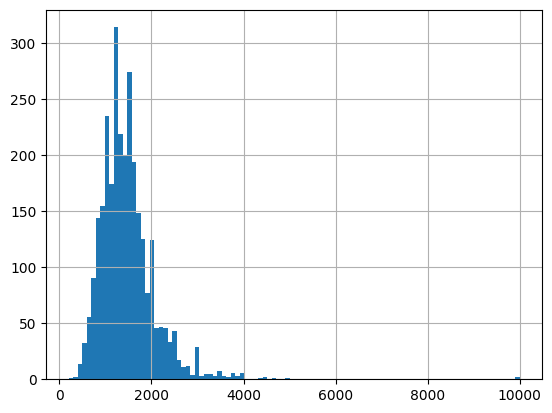

In [25]:
df_cic['date'] = pd.to_datetime(df_cic['date'], format='%Y-%m-%d')

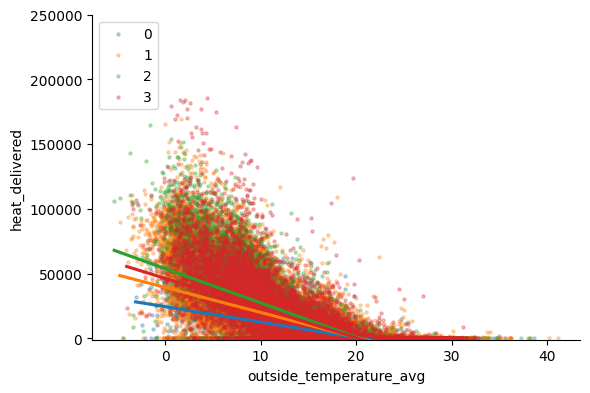

In [33]:
# add heat demand and month to dataframe
df_cic['heat_delivered'] = df_cic[['hp1_heat_generated', 'hp2_heat_generated', 'boiler_heat_generated']].sum(axis=1).astype(float)
df_cic['month'] = df_cic['date'].dt.month
df_cic['dd_month'] = df_cic['month'].apply(lambda x: 0.8 if x in [4, 5, 6, 7, 8, 9] else (1 if x in [3, 10] else 1.1))
df_cic['aardgas_verbruik_cat'] = df_cic['aardgas_verbruik'].apply(lambda x: 0 if x < 1000 else (1 if x < 2000 else (2 if x < 3000 else 3)))
df_cic['outside_temperature_avg'] = df_cic['outside_temperature_avg'].astype(float)

# scatter plot of heat demand per temperature including linear regression
sns.lmplot(x='outside_temperature_avg', y='heat_delivered', data=df_cic, 
           hue='aardgas_verbruik_cat', height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.legend(loc='upper left')
plt.ylim([-1000, 250000])
plt.show()

In [ ]:
# for each cic where temperature is < 15 degrees calculate the average

In [37]:
# add percentage by hp
df_cic['perc_by_hp'] = (df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / df_cic['heat_delivered']).astype(float)
df_cic['COP'] = (df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / (df_cic[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1))).astype(float)

(-0.1, 1.1)

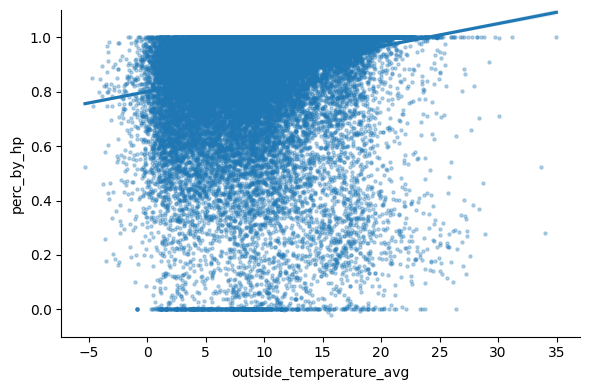

In [42]:
# scatter plot of perc_by_hp per temperature
sns.lmplot(x='outside_temperature_avg', y='perc_by_hp', 
           data=df_cic[df_cic['heat_delivered']>1000], height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.ylim([-0.1, 1.1])

(0.0, 10.0)

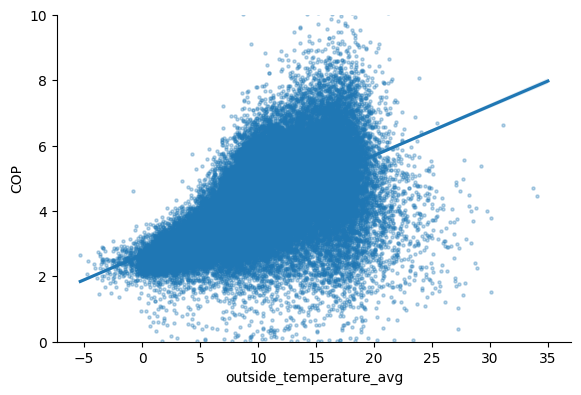

In [45]:
# scatter plot of COP per temperature
COP_temp = sns.lmplot(x='outside_temperature_avg', y='COP', 
           data=df_cic[(df_cic['COP']>0) & (df_cic['heat_delivered']>1000)], 
             height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.ylim([0,10])

In [58]:
df_cic_clean = (
    df_cic[
        (df_cic['COP']>0) 
        & (df_cic['heat_delivered']>1000)
        & (~df_cic['COP'].isna())
        & (~df_cic['perc_by_hp'].isna())
        & (~df_cic['heat_delivered'].isna())
        & (~df_cic['outside_temperature_avg'].isna())
    ]
)

Text(0.5, 1.0, 'heat_delivered per temperature')

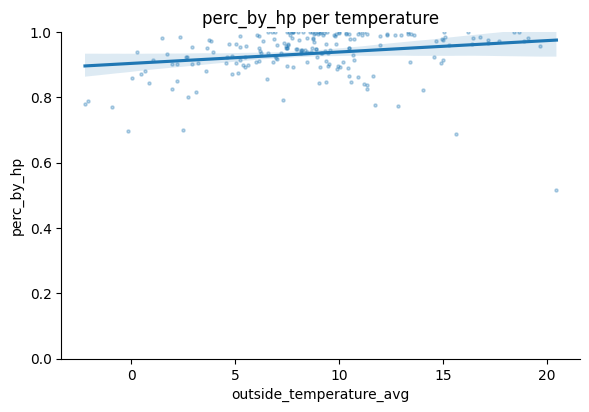

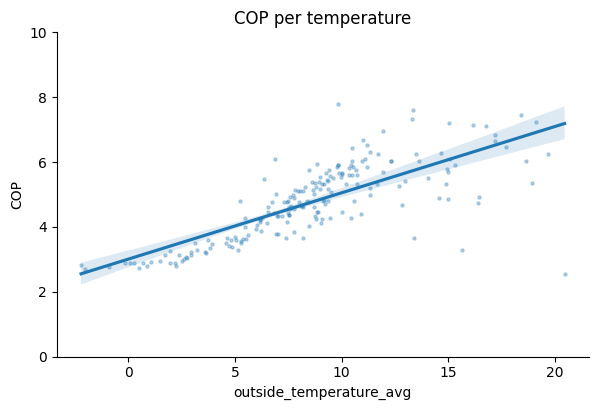

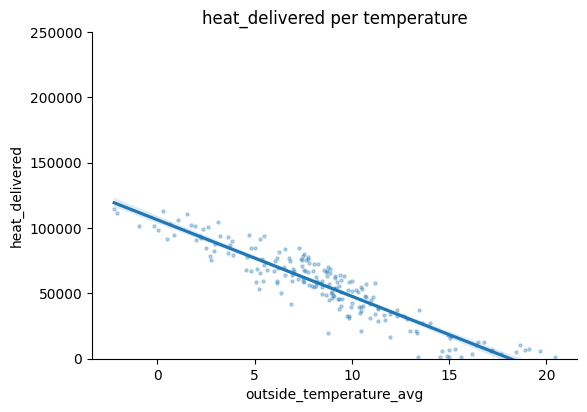

In [77]:
# scatter plot of perc_by_hp per temperature
sns.lmplot(x='outside_temperature_avg', y='perc_by_hp', 
           data=df_cic_clean[df_cic_clean['cic_id']=='CIC-17fcd27d-dbd7-561c-887e-faf59bb9ebeb'], height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.ylim([0, 1])
plt.title('perc_by_hp per temperature')

# scatter plot of COP per temperature
COP_temp = sns.lmplot(x='outside_temperature_avg', y='COP', 
           data=df_cic_clean[df_cic_clean['cic_id']=='CIC-17fcd27d-dbd7-561c-887e-faf59bb9ebeb'], 
             height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.ylim([0,10])
plt.title('COP per temperature')

# scatter plot of heat_delivered per temperature
COP_temp = sns.lmplot(x='outside_temperature_avg', y='heat_delivered', 
           data=df_cic_clean[df_cic_clean['cic_id']=='CIC-17fcd27d-dbd7-561c-887e-faf59bb9ebeb'], 
             height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.ylim([0,250000])
plt.title('heat_delivered per temperature')

In [101]:
# make df_cic_summary which counts nr of rows per cic and sums heat_delivered
df_cic_summary = df_cic.groupby('cic_id').agg({'heat_delivered': 'sum', 
                                               'hp1_heat_generated': 'sum',
                                                'hp2_heat_generated': 'sum',
                                                'boiler_heat_generated': 'sum',
                                                'hp1_energy_consumed': 'sum',
                                                'hp2_energy_consumed': 'sum',
                                               'date': 'count'}).reset_index()
df_cic_summary['perc_by_hp'] = (df_cic_summary[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / df_cic_summary['heat_delivered']).astype(float)
df_cic_summary['COP'] = (df_cic_summary[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / (df_cic_summary[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1))).astype(float)
df_cic_summary['hp_heat_generated'] = df_cic_summary[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1)
df_cic_summary['hp_energy_consumed'] = df_cic_summary[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1)

Text(0, 0.5, 'Number of CICs')

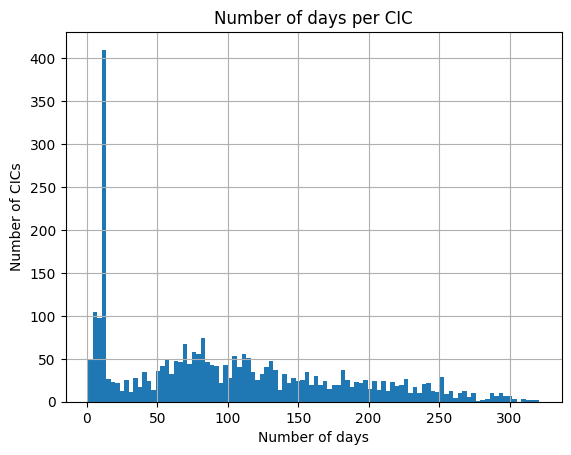

In [96]:
# nr. of days per cic
df_cic_summary['date'].hist(bins=100)
plt.title('Number of days per CIC')
plt.xlabel('Number of days')
plt.ylabel('Number of CICs')

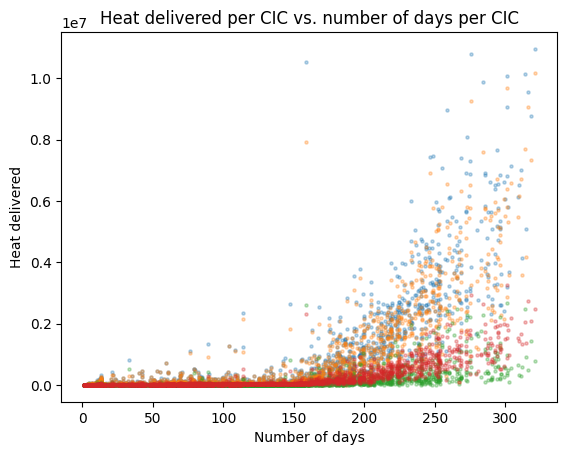

In [102]:
# scatter heat delivered per cic vs. nr of days per cic
plt.scatter(df_cic_summary['date'], df_cic_summary['heat_delivered'], s=5, alpha=0.3)
plt.scatter(df_cic_summary['date'], df_cic_summary['hp_heat_generated'], s=5, alpha=0.3)
plt.scatter(df_cic_summary['date'], df_cic_summary['boiler_heat_generated'], s=5, alpha=0.3)
plt.scatter(df_cic_summary['date'], df_cic_summary['hp_energy_consumed'], s=5, alpha=0.3)
plt.title('Heat delivered per CIC vs. number of days per CIC')
plt.xlabel('Number of days')
plt.ylabel('Heat delivered')
plt.show()

# Fit trendlines through each of the scatters
# heat delivered
x = df_cic_summary['date']
y = df_cic_summary['heat_delivered']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# scatter heat by hp delivered vs. nr of days per cic

# plt.title('Heat by HP delivered per CIC vs. number of days per CIC')
# plt.xlabel('Number of days')
# plt.ylabel('Heat by HP delivered')
# plt.show()

# scatter boiler heat generated  vs. nr of days per cic

# plt.title('Boiler heat generated per CIC vs. number of days per CIC')
# plt.xlabel('Number of days')
# plt.ylabel('Boiler heat generated')


Test with dbscan

In [115]:
X = df_cic_clean[['outside_temperature_avg', 'perc_by_hp', 'heat_delivered','COP']].values
# Standardize the data
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=10, min_samples=20)
clusters = dbscan.fit_predict(scaled_X)

# count number of different clusters
print(np.unique(clusters, return_counts=True))

# Plot result
plt.scatter(scaled_X[:,0], scaled_X[:,2], c=clusters, cmap='plasma')

(array([-1,  0]), array([   52, 56512]))


In [68]:
# create array with temperatures -5 - 35
temps = [i for i in range(-5, 36)]

slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_cic_clean['outside_temperature_avg'],
    df_cic_clean['COP'])
print(slope, intercept)

0.15221949504495377 2.6517109233687552


# explorative analysis

,id,created_at,updated_at,deal_id,orderNr,aanbevolen_vermogen_warmtepomp,referentie_warmtevraag_per_m2,geschiktheid_woning,aardgas_verbruik,bouwjaar,...,elektriciteit,gas,kosten_extra_elektra_verbruik,besparing_minder_gas_verbruik,besparing,investering,subsidie,netto_kosten,terugverdientijd,terugverdientijd_jaren
0,1,2023-09-07 15:24:49,2023-09-07 15:24:49,2147483647,QUATT3906,4,67.00,goed geschikt,450.0,Na 2000,...,0.60,2.31,249.12,441.79,192.67,4849.0,2700.0,2149.0,11 jaar en 2 maanden,11.15
1,2,2023-09-07 15:24:49,2023-09-07 15:24:49,2147483647,QUATT6324,4,72.38,goed geschikt,1559.0,Tussen 1970 en 1990,...,0.40,1.45,835.47,1395.03,559.56,5199.0,2700.0,2499.0,4 jaar en 6 maanden,4.47
2,3,2023-09-07 15:24:49,2023-09-07 15:24:49,2147483647,QUATT4133,4,77.75,goed geschikt,1250.0,Tussen 1970 en 1990,...,0.60,2.31,1022.85,1813.91,791.06,4849.0,2700.0,2149.0,2 jaar en 9 maanden,2.72
3,4,2023-09-07 15:24:49,2023-09-07 15:24:49,2147483647,QUATT2495,4,67.00,goed geschikt,1534.0,Na 2000,...,0.60,2.31,1191.29,2112.61,921.33,4849.0,2700.0,2149.0,2 jaar en 4 maanden,2.33
4,5,2023-09-07 15:24:49,2023-09-07 15:24:49,2147483647,QUATT1970,4,67.00,uitmuntend,1400.0,Voor 1970,...,0.40,1.45,683.49,1318.78,635.29,4849.0,2700.0,2149.0,3 jaar en 5 maanden,3.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869,2870,2023-09-08 10:02:42,2023-09-08 10:02:42,2147483647,QUATT1503,4,67.00,uitmuntend,1600.0,Voor 1970,...,0.60,2.31,1184.95,2428.25,1243.30,4849.0,2700.0,2149.0,1 jaar en 9 maanden,1.73
2870,2871,2023-09-08 10:02:42,2023-09-08 10:02:42,2147483647,QUATT1259,4,80.44,matig geschikt,2000.0,Voor 1970,...,0.60,2.31,938.67,1479.67,541.00,4849.0,2700.0,2149.0,3 jaar en 12 maanden,3.97
2871,2872,2023-09-08 10:02:42,2023-09-08 10:02:42,2147483647,QUATT25,4,67.00,goed geschikt,1668.0,Voor 1970,...,0.73,3.27,1634.24,3371.96,1737.72,4299.0,2700.0,1599.0,en 12 maanden,0.92
2872,2873,2023-09-08 10:02:42,2023-09-08 10:02:42,2147483647,QUATT2769,8,88.50,zeer geschikt,3000.0,Tussen 1970 en 1990,...,0.40,1.45,1641.94,2985.32,1343.38,8349.0,5400.0,2949.0,2 jaar en 3 maanden,2.20
